In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import networkx as nx
from fuzzywuzzy import fuzz
from collections import defaultdict

import _pickle as cPickle
import re
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.porter import *
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases
import multiprocessing

%matplotlib inline

/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/admin0/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
df = pd.read_csv('data/train_min.csv')
df_test = pd.read_csv('data/test_min.csv')

In [32]:
df.columns

Index(['word_match', 'tfidf_wm', 'tfidf_wm_stops', 'jaccard', 'wc_diff',
       'wc_ratio', 'wc_diff_unique', 'wc_ratio_unique', 'wc_diff_unq_stop',
       'wc_ratio_unique_stop', 'same_start', 'char_diff', 'char_diff_unq_stop',
       'total_unique_words', 'total_unq_words_stop', 'char_ratio', 'len_q1',
       'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1',
       'len_word_q2', 'common_words', 'fuzz_qratio', 'fuzz_WRatio',
       'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_token_sort_ratio', 'wmd', 'norm_wmd', 'cosine_distance',
       'cityblock_distance', 'canberra_distance', 'minkowski_distance',
       'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
       'q1_q2_intersect', 'q1_freq', 'q2_freq', 'is_duplicate', 'wmd12',
       'wmd1', 'wmd2', 'd2v_sim'],
      dtype='object')

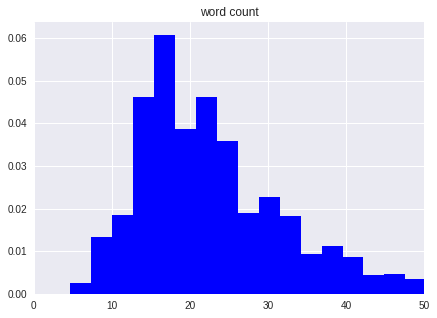

In [10]:
plt.figure(figsize=(7,5))
plt.hist(df[df['is_duplicate'] == 0]['wc_q1'].values+df[df['is_duplicate'] == 0]['wc_q2'], color='b', bins=100, normed=True)
plt.xlim([0,50])
plt.title('word count')
plt.savefig('fig/wc.png')

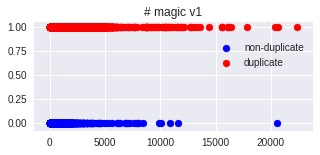

In [27]:
fig = plt.figure(figsize=(5,2))
for i,c,t in zip([0,1],['b','r'],['non-duplicate','duplicate']):
    tdf = df[df['is_duplicate']==i]
    plt.scatter(tdf['q1_freq']*tdf['q2_freq'], tdf['is_duplicate'], c=c, label=t)
plt.title('# magic v1')
plt.legend(loc=4, bbox_to_anchor=(1,0.5))
plt.savefig('fig/magic-v1.png')

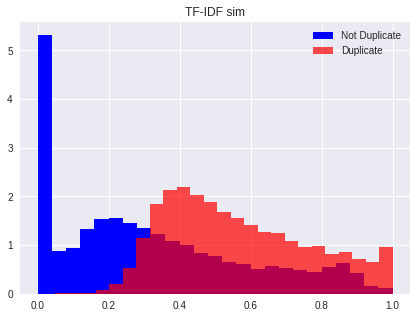

In [30]:
c = 'tfidf_wm'
plt.figure(figsize=(7,5))
plt.hist(df[df['is_duplicate'] == 0][c], color='b', bins=25, normed=True, label='Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1][c], color='r', bins=25, normed=True, alpha=0.7, label='Duplicate')
plt.legend(loc=1)
plt.title('TF-IDF sim')
plt.savefig('fig/corr-tfidf-sim.png')

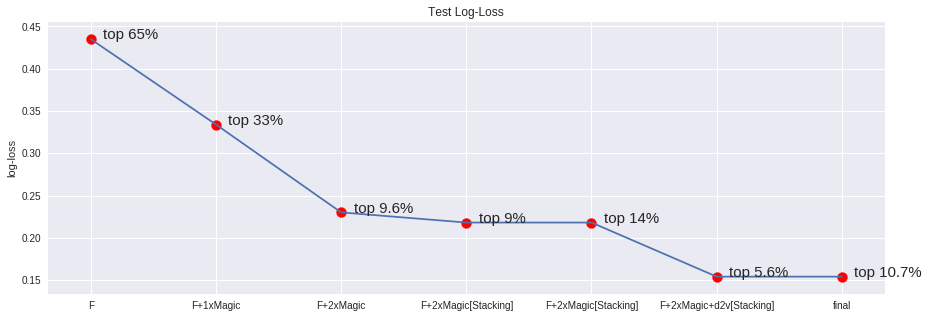

In [10]:
x=['F','F+1xMagic','F+2xMagic', 'F+2xMagic[Stacking]', 'F+2xMagic[Stacking]', 'F+2xMagic+d2v[Stacking]', 'final']
tp = ['top 65%', 'top 33%', 'top 9.6%', 'top 9%', 'top 14%', 'top 5.6%', 'top 10.7%']
yt=[0.435, 0.334, 0.230, 0.218, 0.218, 0.154, 0.154]

fig = plt.figure(figsize=(15,5))
plt.plot(range(len(yt)), yt)
plt.scatter(range(len(yt)), yt, c='r', s=100)
for i in range(len(yt)):
    plt.text(i+0.1, yt[i], tp[i], fontsize=15)
plt.xticks(range(len(x)), x)
plt.title('Test Log-Loss')
plt.ylabel('log-loss')
plt.savefig('fig/test-progress.png')

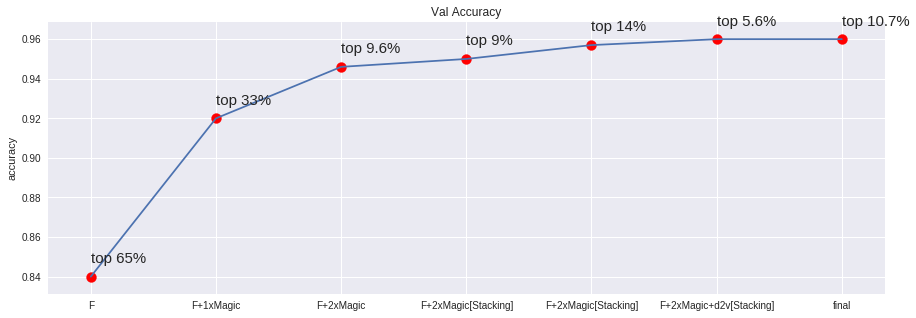

In [41]:
x=['F','F+1xMagic','F+2xMagic', 'F+2xMagic[Stacking]', 'F+2xMagic[Stacking]', 'F+2xMagic+d2v[Stacking]', 'final']
tp = ['top 65%', 'top 33%', 'top 9.6%', 'top 9%', 'top 14%', 'top 5.6%', 'top 10.7%']
yt=[0.84, 0.92, 0.946, 0.95, 0.957, 0.96, 0.96]

fig = plt.figure(figsize=(15,5))
plt.plot(range(len(yt)), yt)
plt.scatter(range(len(yt)), yt, c='r', s=100)
for i in range(len(yt)):
    plt.text(i, yt[i]+0.007, tp[i], fontsize=15)
plt.xticks(range(len(x)), x)
plt.title('Val Accuracy')
plt.ylabel('accuracy')
plt.savefig('fig/vacc-progress.png')

In [75]:
q1, q2 = df[['question1']].copy(), df[['question2']].copy().rename(columns = {'question2':'question1'},inplace=False)
Q = q1.append(q2)
Q = pd.DataFrame({'question':Q['question1']})
q1, q2 = df[['question1']].copy(), df[['question2']].copy().rename(columns = {'question2':'question1'},inplace=False)
Q_test = q1.append(q2)
Q_test = pd.DataFrame({'question':Q_test['question1']})

In [145]:
qmarks = np.mean(Q['question'].astype(str).apply(lambda x: '?' in x))
abbrev = np.mean(Q['question'].astype(str).apply(lambda x: '\'' in x))
math = np.mean(Q['question'].astype(str).apply(lambda x: '[math]' in x))
fullstop = np.mean(Q['question'].astype(str).apply(lambda x: '.' in x))
capital_first = np.mean(Q['question'].astype(str).apply(lambda x: x[0].isupper()))
capitals = np.mean(Q['question'].astype(str).apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(Q['question'].astype(str).apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with abbrevation: {:.2f}%'.format(abbrev * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with abbrevation: 8.74%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%
